In [2]:
from _SBMMatrix import *
from _FigureJiazeHelper import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from _CommunityDetect import *
from spectralOperator import BetheHessian
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [3]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

# General SBM

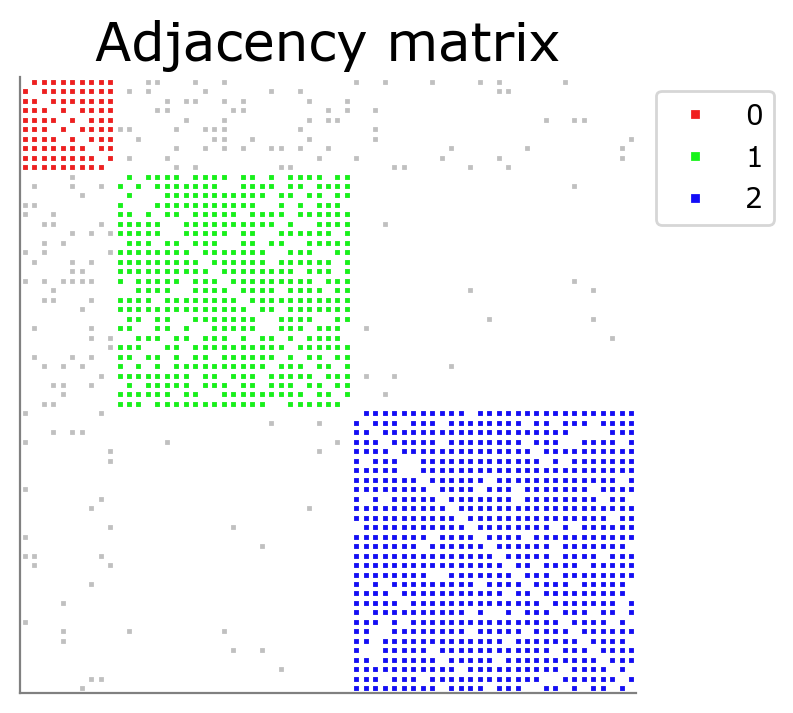

In [58]:
# Any Shape
sizes = [10, 25, 30]
ps = [[0.9, 0.2, 0.1], [0.2, 0.8, 0.02], [0.1, 0.02, 0.9]]
sbm = SBMMatrix(sizes, ps)
d = np.sum(sbm.A) / np.sum(sizes)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

In [4]:
def scatter_spectral(eigvalue, fig=None, ax=None, title='Spectrum'):
    # Construct scatter coordinate
    x = []
    y = []
    for _w in eigvalue:
        _x = _w.real if isinstance(_w, complex) else _w
        _y = _w.imag if isinstance(_w, complex) else 0
        x.append(_x)
        y.append(_y)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(8, 8))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
    plt.axis('equal')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.scatter(x, y, s=6)
    ax.set_title(title)

In [34]:
def plot_spectral_NBBH(sbm, d):
    print(f'SNR={sbm.get_SNR()}, d={d}')
    NB = sbm.get_operator('NB')
    print(np.shape(NB))
    eig_B, _ = eig(NB.toarray())
    info_eig = []
    for e in eig_B:
        if abs(e) > np.sqrt(d) and e.imag == 0:
            info_eig.append(e)
    print(info_eig)
    fig = plt.figure(figsize=(8, 4))
    widths = [5]
    heights = [5]
    spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_B, fig=fig, ax=ax, title=r"Spectrum of $\mathrm{NB}$ and $\mathrm{BH}$")
    ax.add_patch(Circle(xy = (0.0, 0.0), radius=np.sqrt(d), alpha=0.2))
    
    bh_samples = 40
    c = gen_colors(start=colors_red[0], end=colors_green[0], n=bh_samples)
    i = 0
    eig_BHs = dict()
    eig_max = 0
    for r in np.linspace(np.sqrt(d), max(info_eig).real+1, bh_samples):
        BH = sbm.get_operator('BH', r=r)
        eig_BH, _ = eig(BH.toarray())
        eig_BHs[r] = eig_BH
    eig_max = max(eig_BHs[max(info_eig).real+1])
    for r in np.linspace(np.sqrt(d), max(info_eig).real+1, bh_samples):
        eig_BH = eig_BHs[r]
        x = []
        y = []
        for _w in eig_BH:
            _y = _w.real if isinstance(_w, complex) else _w
            _y = _y / eig_max * 5 * np.sqrt(d) # normalize
            x.append(r)
            y.append(_y)
        ax.scatter(x, y, s=2, c=c[i])
        i += 1
    ax.set_ylim(-np.sqrt(d), 1 * np.sqrt(d))
    ax.set_xlim(-np.sqrt(d)-1, max(info_eig).real+2)
    for e in info_eig:
        ax.axvline(e.real, c='black', ls=':', lw=1)
#     x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
#     axins = ax.inset_axes(
#         [0.5, 0.5, 0.47, 0.47],
#         xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
#     axins.imshow(Z2, extent=extent, origin="lower")

#     ax.indicate_inset_zoom(axins, edgecolor="black")
#     BH = sbm.get_operator('BH', r=np.sqrt(d))
#     eig_BH, _ = eig(BH.toarray())
#     info_eig = []
#     for e in eig_BH:
#         if e < 0:
#             info_eig.append(e)
#     print(info_eig)
#     row = 0
#     col = 1
#     ax = fig.add_subplot(spec5[row, col])
#     scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with pos r")
    
#     BH = sbm.get_operator('BH', r=-np.sqrt(d))
#     eig_BH, _ = eig(BH.toarray())
#     info_eig = []
#     for e in eig_BH:
#         if e < 0:
#             info_eig.append(e)
#     print(info_eig)
#     row = 1
#     col = 1
#     ax = fig.add_subplot(spec5[row, col])
#     scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with neg r")

SNR=15.708509588268559, d=23.53846153846154
(1530, 1530)
[(25.1331754522255+0j), (19.408626592334574+0j)]
[-77.40134430791935, -54.78407624192896]


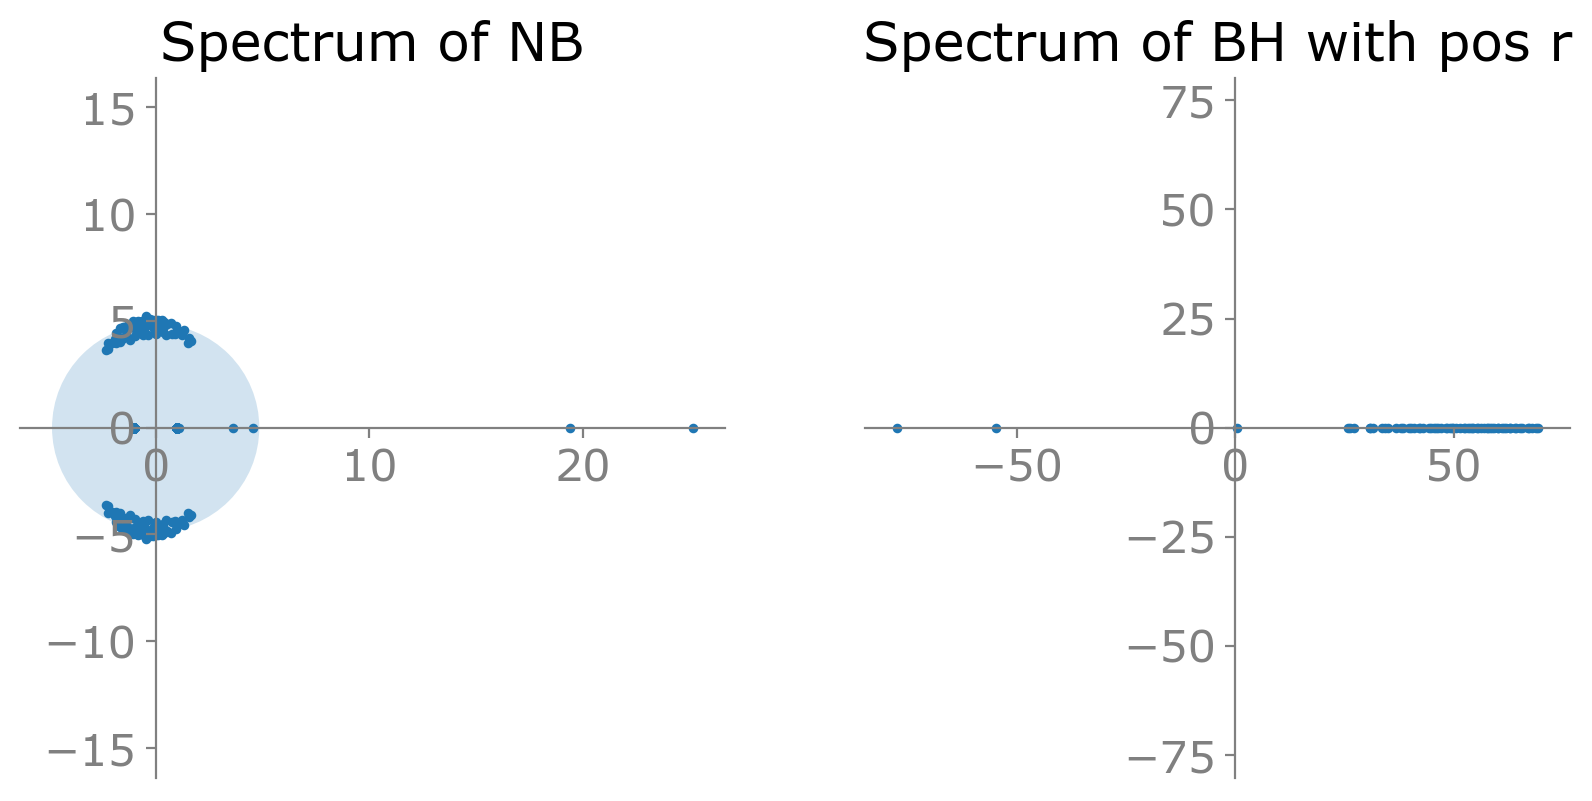

In [59]:
plot_spectral_NBBH(sbm, d)

# SSBM

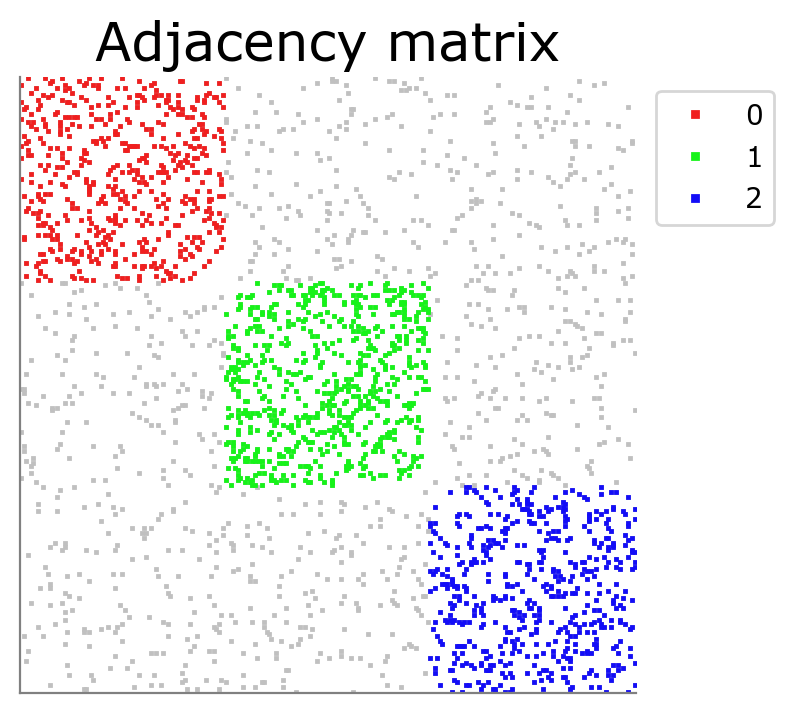

In [60]:
# Symmetric
n = 2**8
k = 3
d = 10
epsilon = 0.3
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

SNR=1.9140625, d=10
(2618, 2618)
[(10.165805993945796+0j), (4.873175471357438+0j), (3.4685246582367366+0j)]
[-14.693539946707197, -1.6862878575545892, -0.11389733751078462]


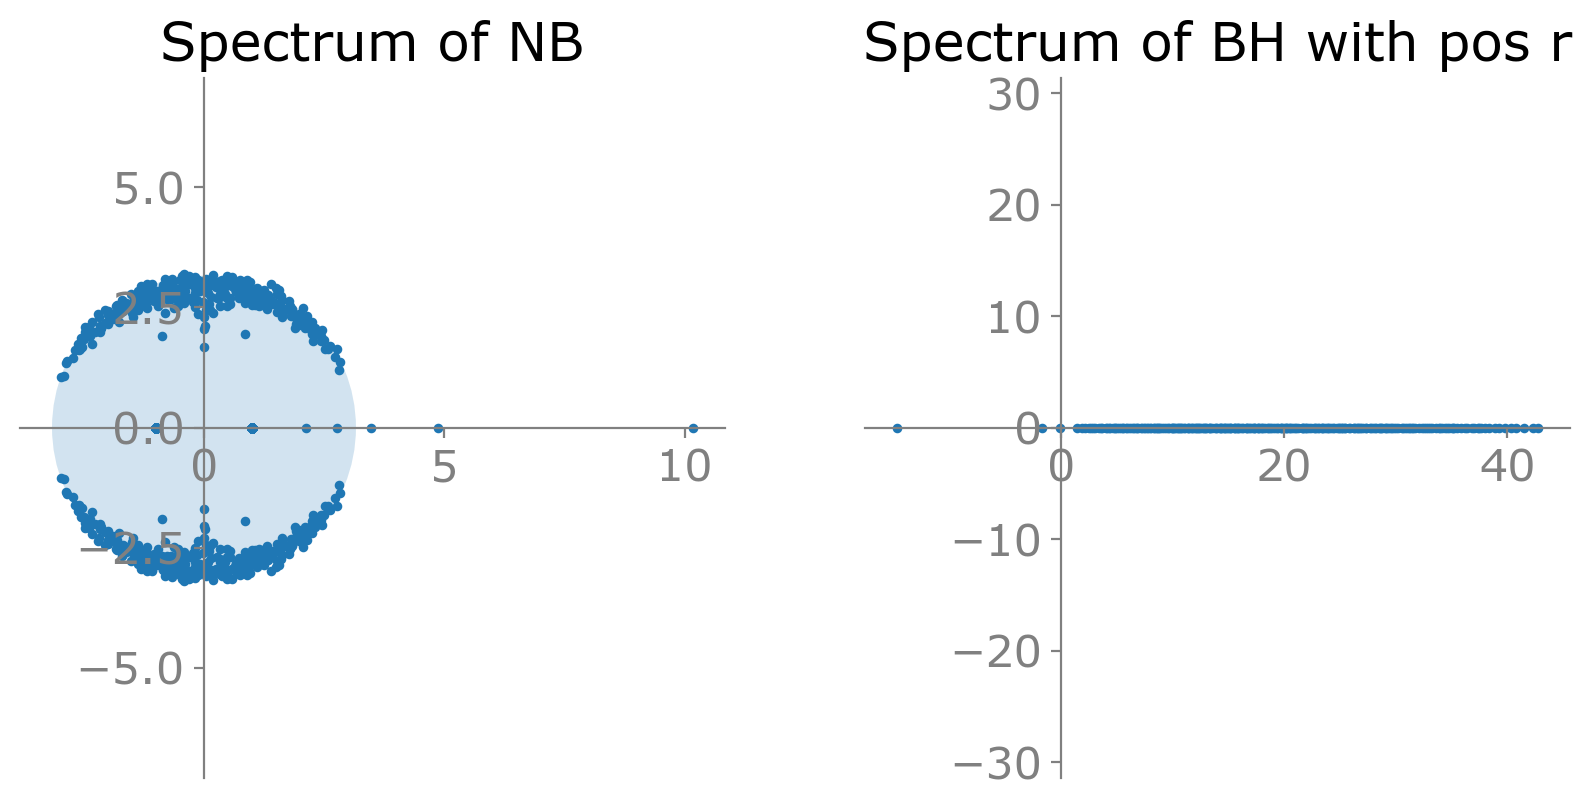

In [61]:
plot_spectral_NBBH(net, d)

# BSBM

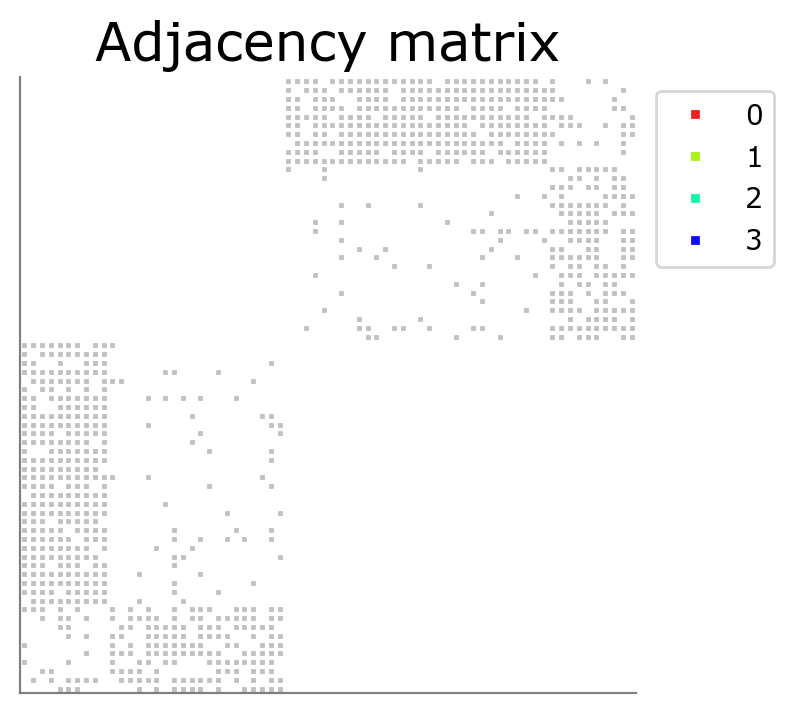

In [66]:
k1 = 2
k2 = 2
sizes = [10, 20, 30, 10]
H = [[0.9, 0.2], [0.1, 0.7]]
sbm = BipartiteSBM(k1, k2, sizes, H)
d = np.sum(sbm.A) / np.sum(sizes)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

SNR=16.3571296279829, d=13.942857142857143
(976, 976)
[(-15.523386262330684+0j), (15.52338626233071+0j), (-7.502375135008538+0j), (7.502375135008517+0j)]
[-30.604940270419036, -7.574984291723715]
[-30.604940270419036, -7.574984291723715]


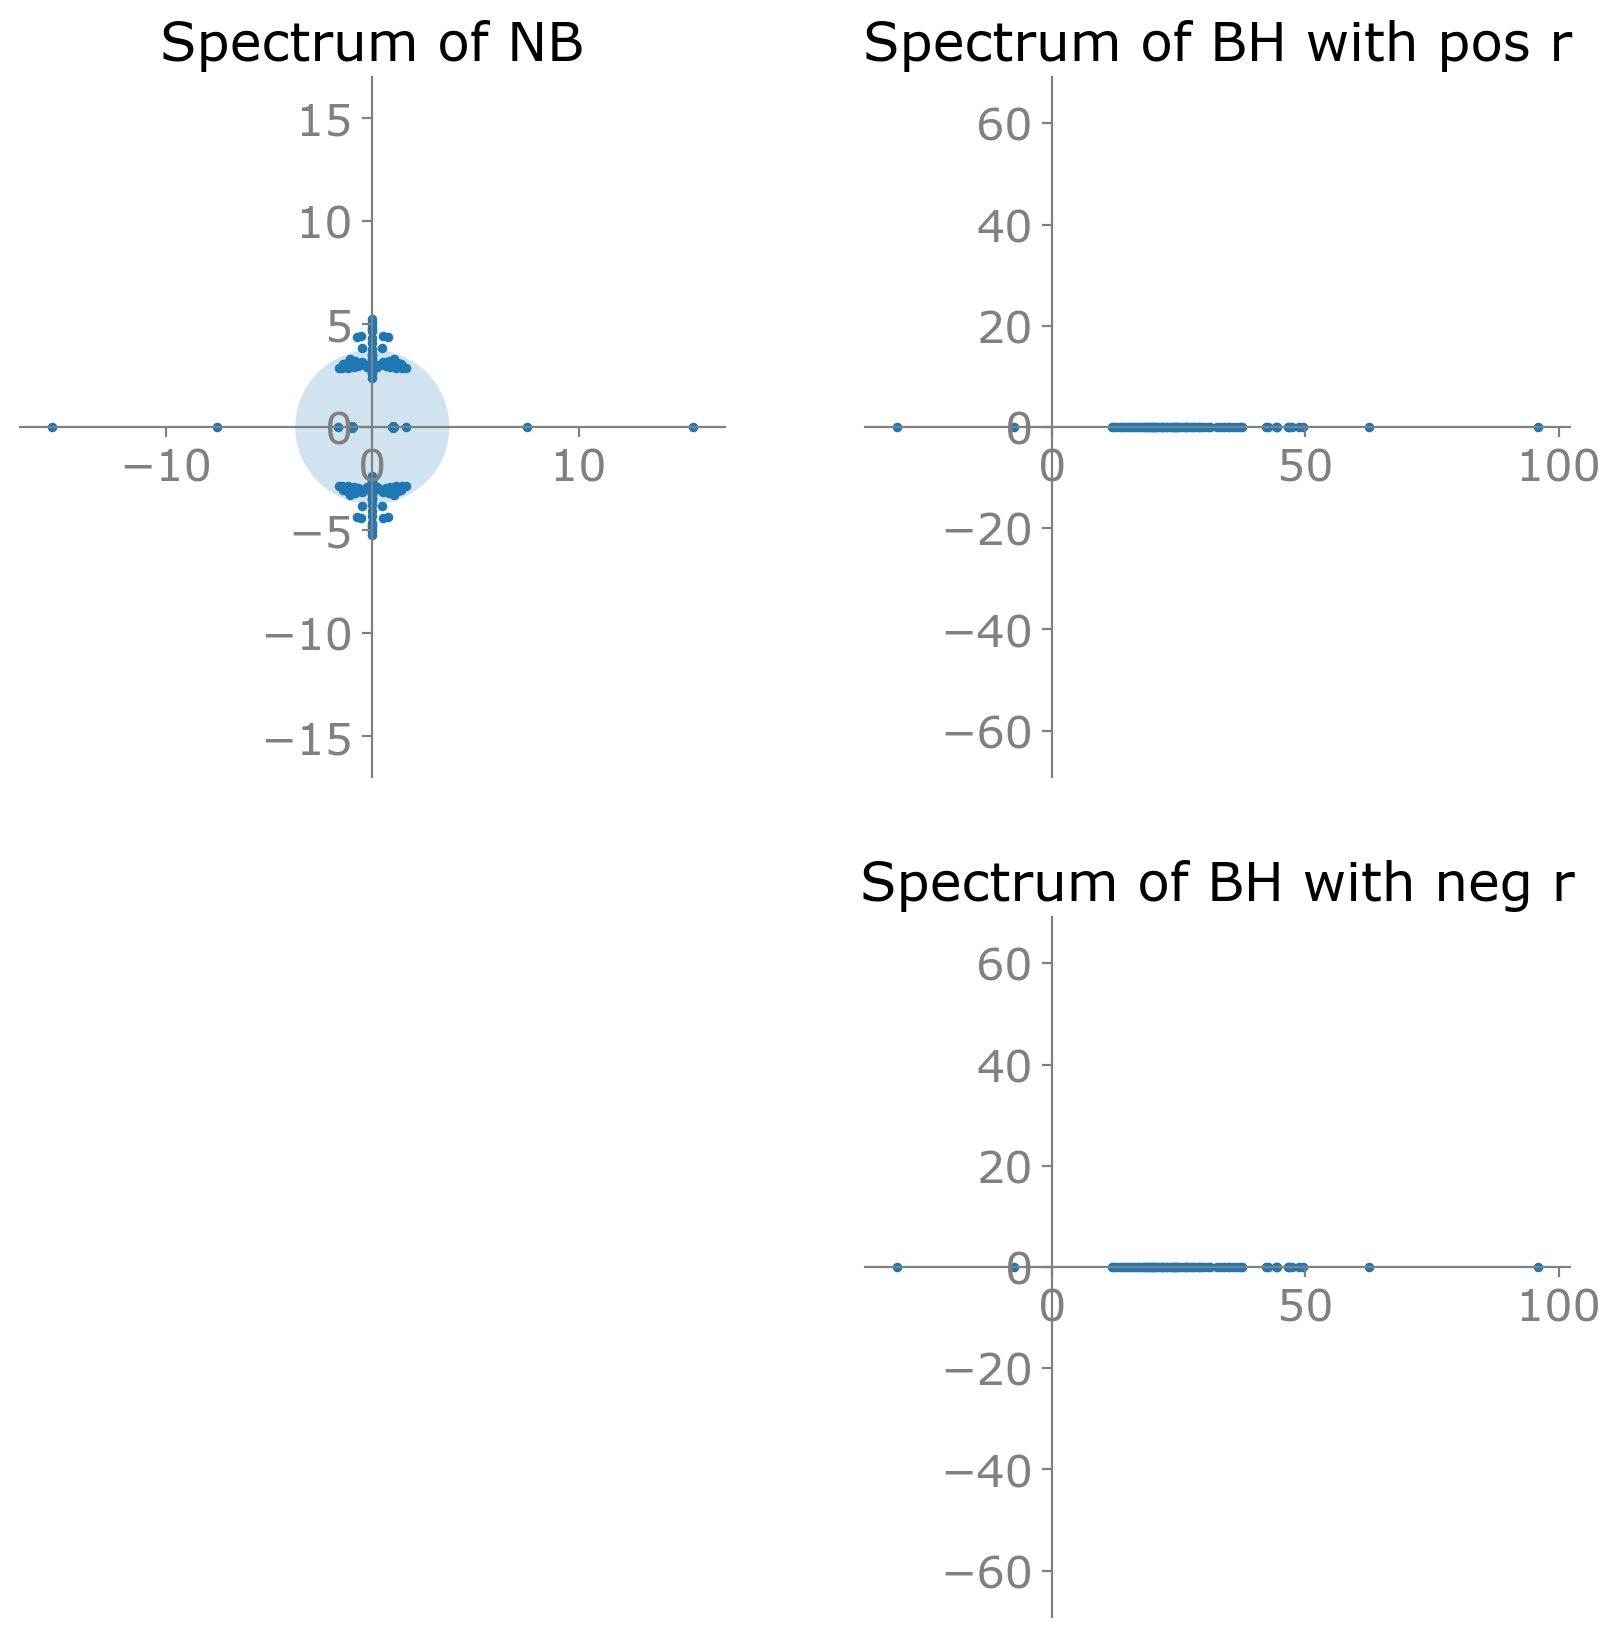

In [70]:
plot_spectral_NBBH(sbm, d)

# Hyper SBM

# of nodes 50, # of edges 421


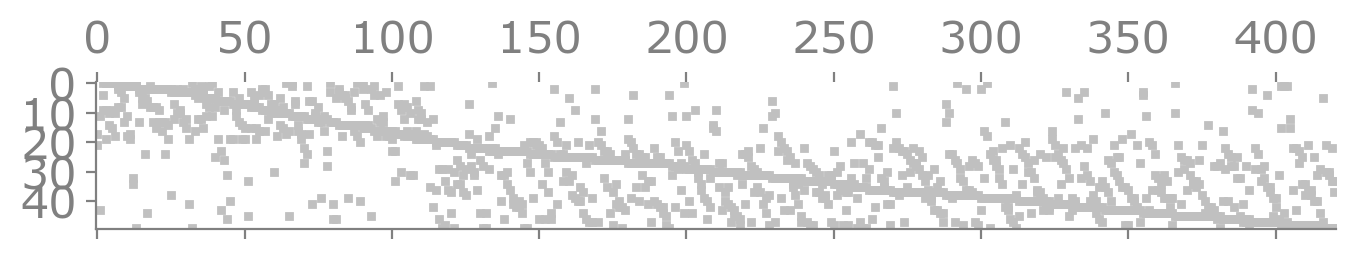

In [25]:
sizes = [20, 30]
ps_dict = {2:[[0.001, 0.001], [0.001, 0.001]], 3:[[[0.01, 0.001], [0.002, 0.001]], [[0.001, 0.001], [0.002, 0.01]]]}
hsbm = HyperSBM(sizes, ps_dict)
print(f'# of nodes {hsbm.n}, # of edges {hsbm.e}')
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
plt.spy(hsbm.H, markersize=2, rasterized=True, color=gray)

average degree of bipartite form is 5.354564755838641
[(-4.648793525146949+0j), (-2.15848934655564+0j)]
[(-4.648793525146949+0j), (-2.15848934655564+0j)]


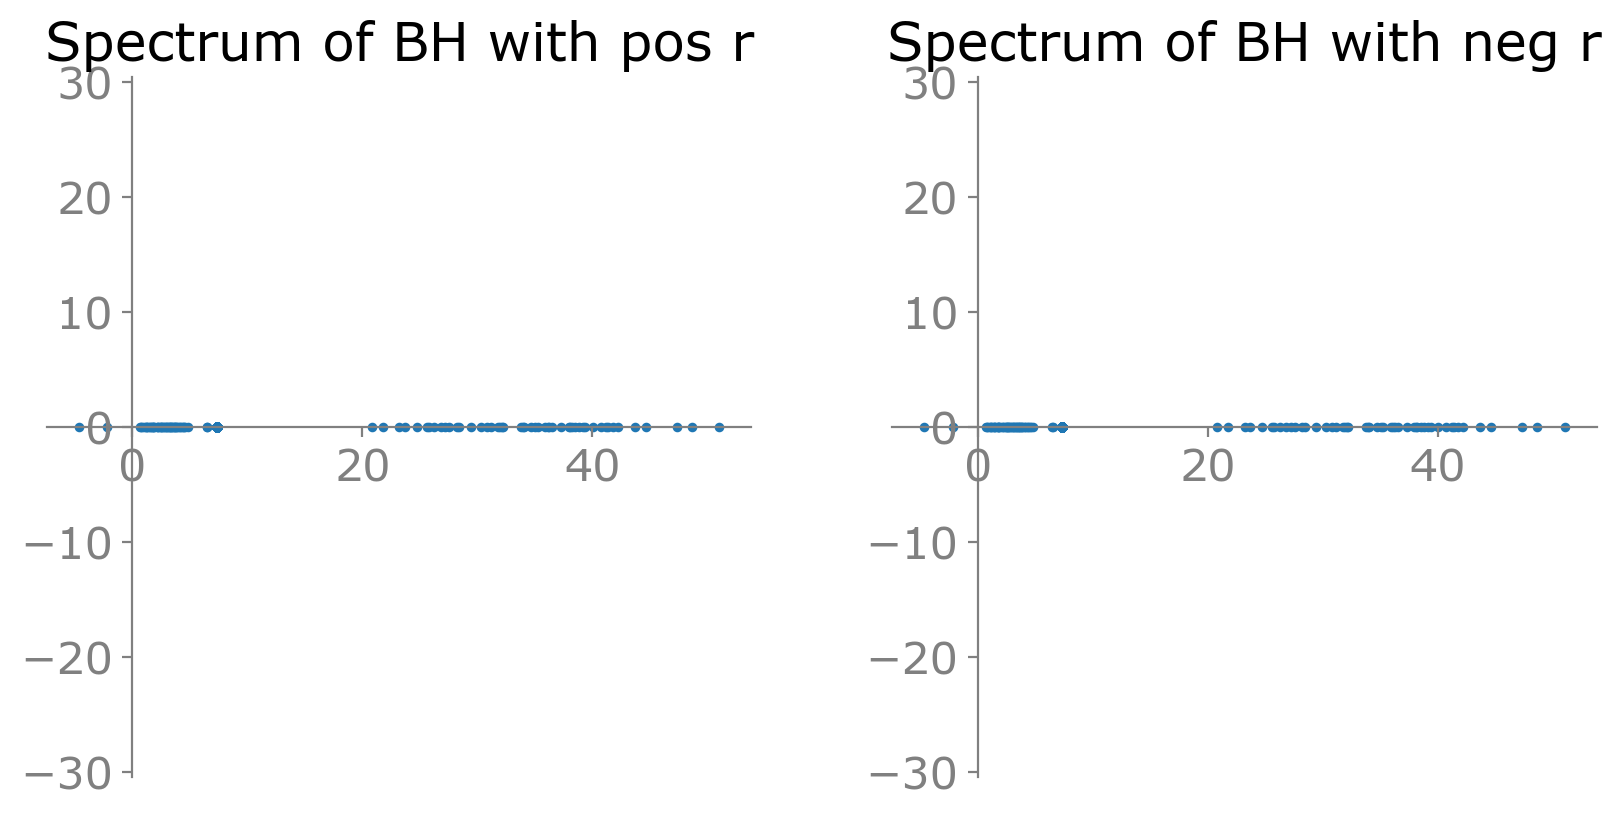

In [26]:
d = np.sum(hsbm.bipartite_A) / (hsbm.n + hsbm.e)
print(f'average degree of bipartite form is {d}')
fig = plt.figure(figsize=(10, 10))
widths = [5, 5]
heights = [5, 5]
spec5 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
BH = hsbm.get_operator('BH', r=np.sqrt(d))
eig_BH, _ = eig(BH.toarray())
info_eig = []
for e in eig_BH:
    if e < 0:
        info_eig.append(e)
print(info_eig)
scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with pos r")

BH = hsbm.get_operator('BH', r=-np.sqrt(d))
eig_BH, _ = eig(BH.toarray())
info_eig = []
for e in eig_BH:
    if e < 0:
        info_eig.append(e)
print(info_eig)
row = 0
col = 1
ax = fig.add_subplot(spec5[row, col])
scatter_spectral(eig_BH, fig=fig, ax=ax, title="Spectrum of BH with neg r")

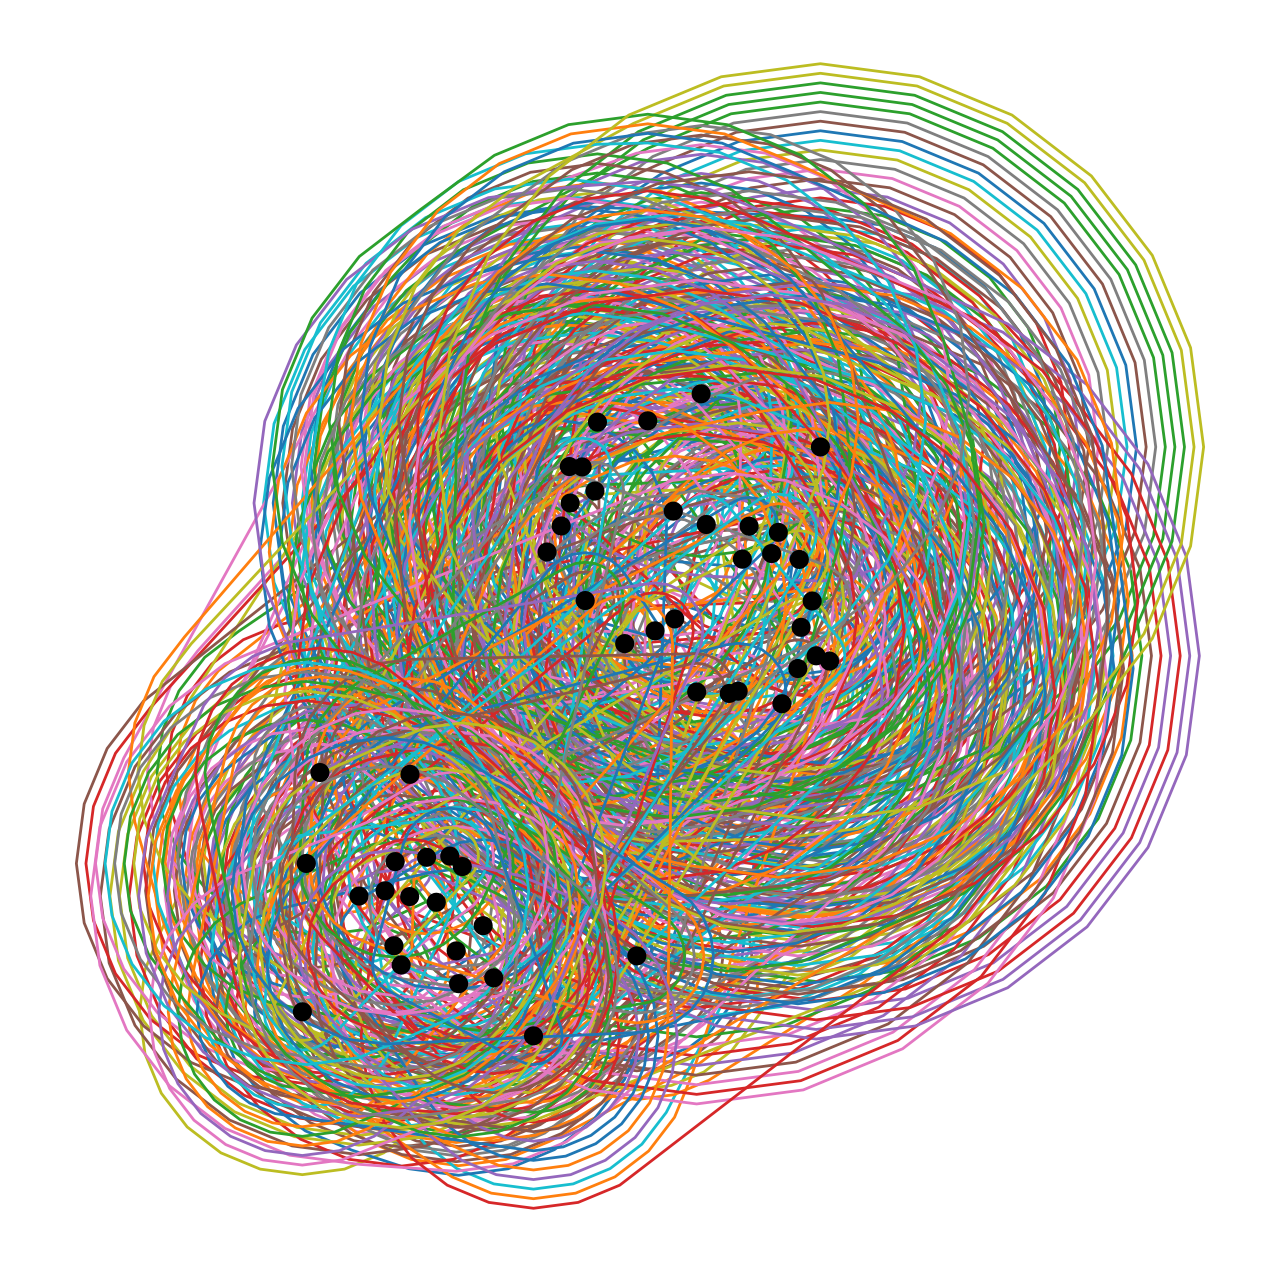

In [27]:
plt.subplots(figsize=(8,8))
hnx.draw(hsbm.hyper_g, with_edge_labels=False, with_node_labels=False)

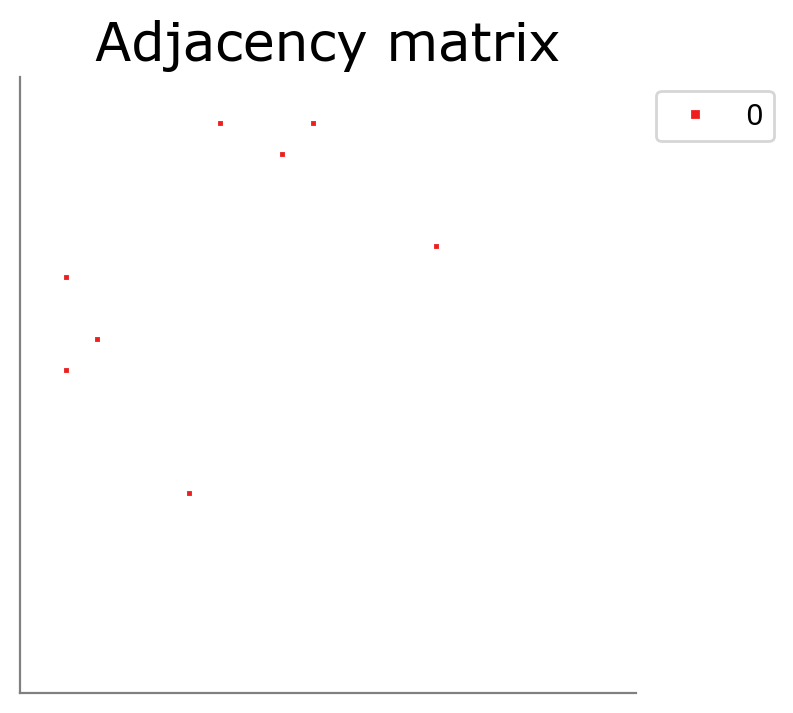

In [15]:
sizes = [20]
ps = [[0.05]]
sbm = SBMMatrix(sizes, ps)
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A, partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

In [16]:
fullpartition, full_num_groups = CommunityDetect(sbm.A).BetheHessian()
full_ami = adjusted_mutual_info_score(np.array([0] * np.sum(sizes)), fullpartition)
print(f'Random graph with p={ps[0][0]}, AMI by BH is {full_ami}, detected number of gcommunity is {full_num_groups}')

Input matrix not in sparse format, transforming to sparse matrix
Input matrix not in sparse format, transforming to sparse matrix
number of groups = 32


ValueError: n_samples=20 should be >= n_clusters=32.

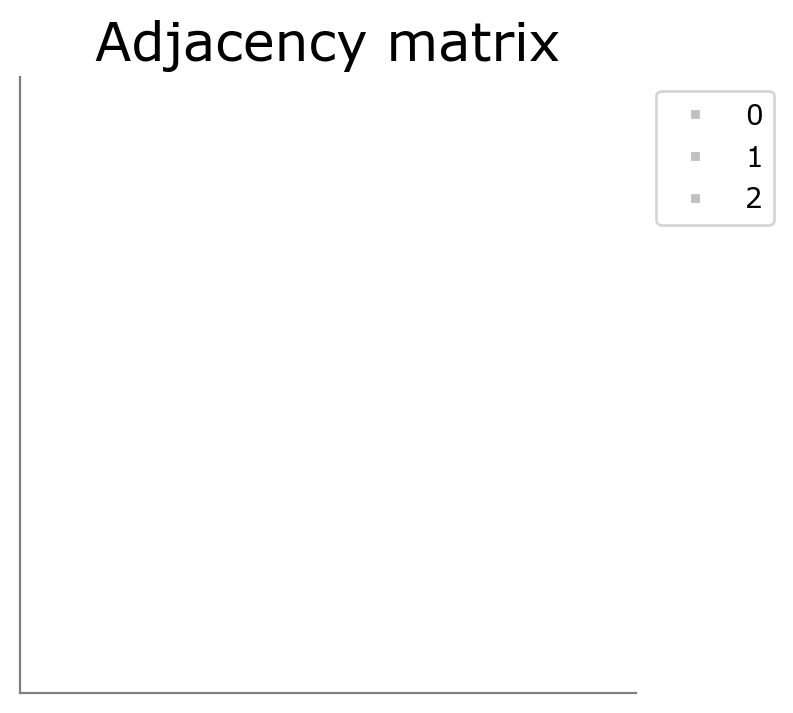

In [22]:
# Symmetric
n = 2**6
k = 3
# d = n-1
# epsilon = 1
# net = SymmetricSBM.init_epsc(n, k, d, epsilon)
# net = SymmetricSBM(n, k, pin=1, pout=0.2)
# net = SymmetricSBM(n, k, pin=1, pout=0)
net = SymmetricSBM(n, k, pin=0, pout=0)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=gray, end=gray, n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

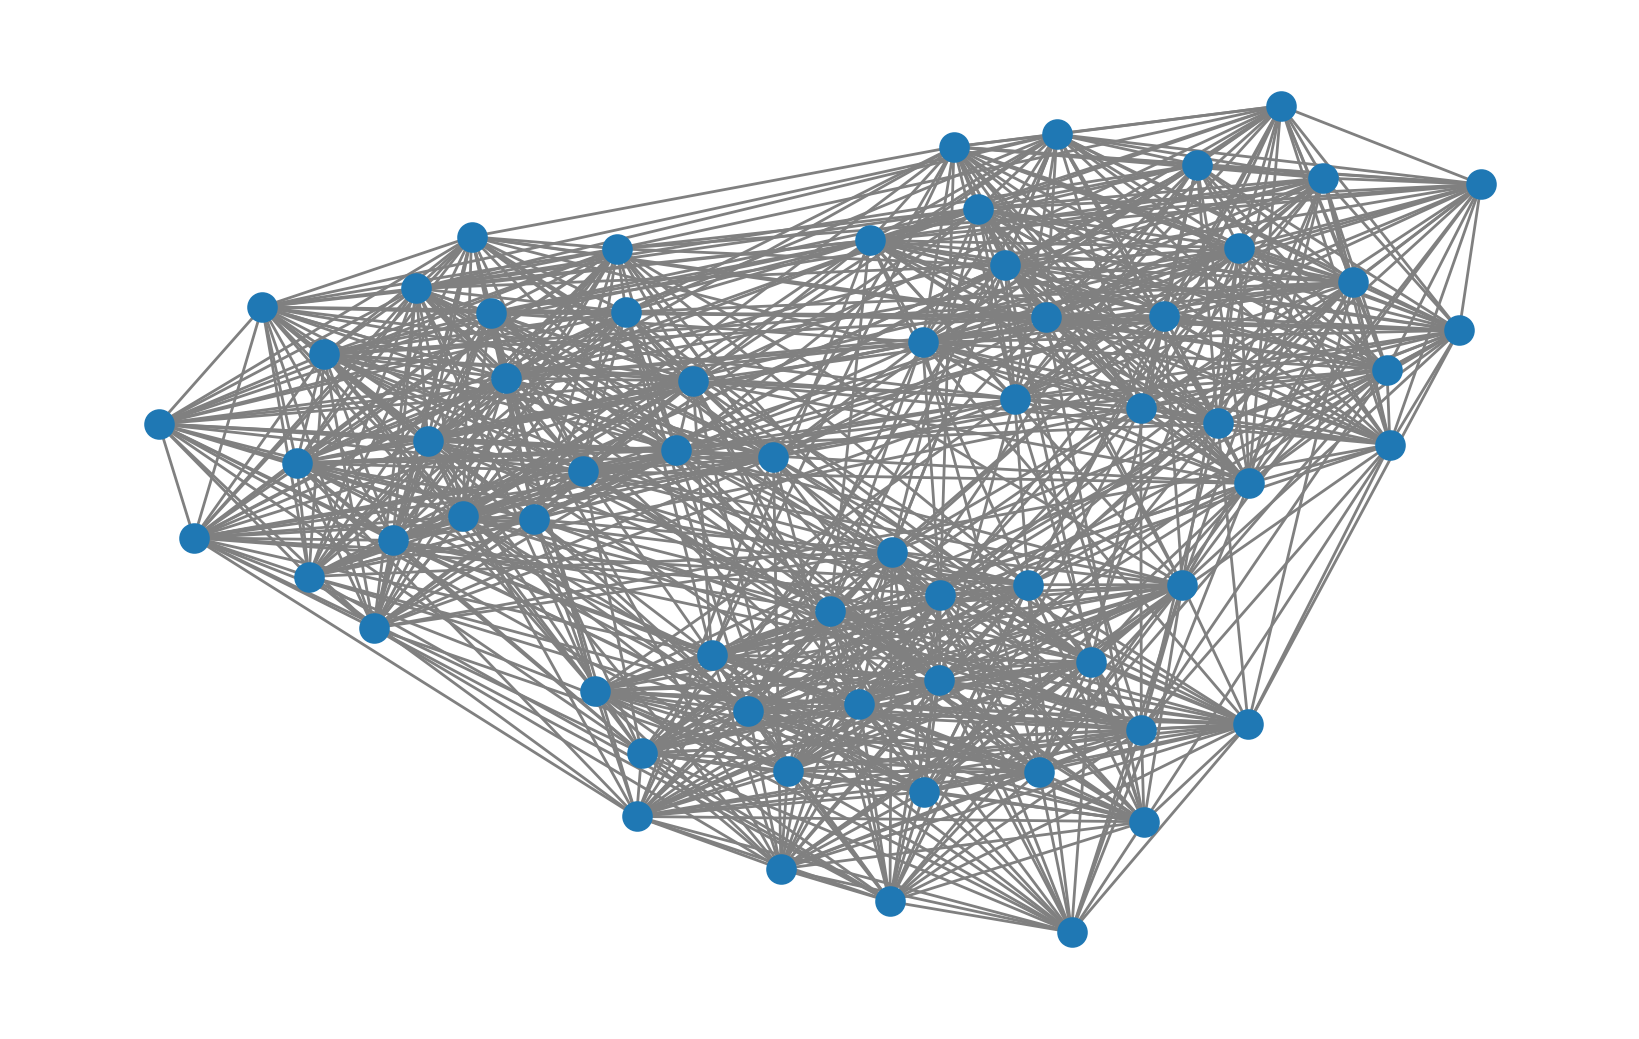

In [15]:
node_color='#1f78b4'
pos = nx.spring_layout(net.g)
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

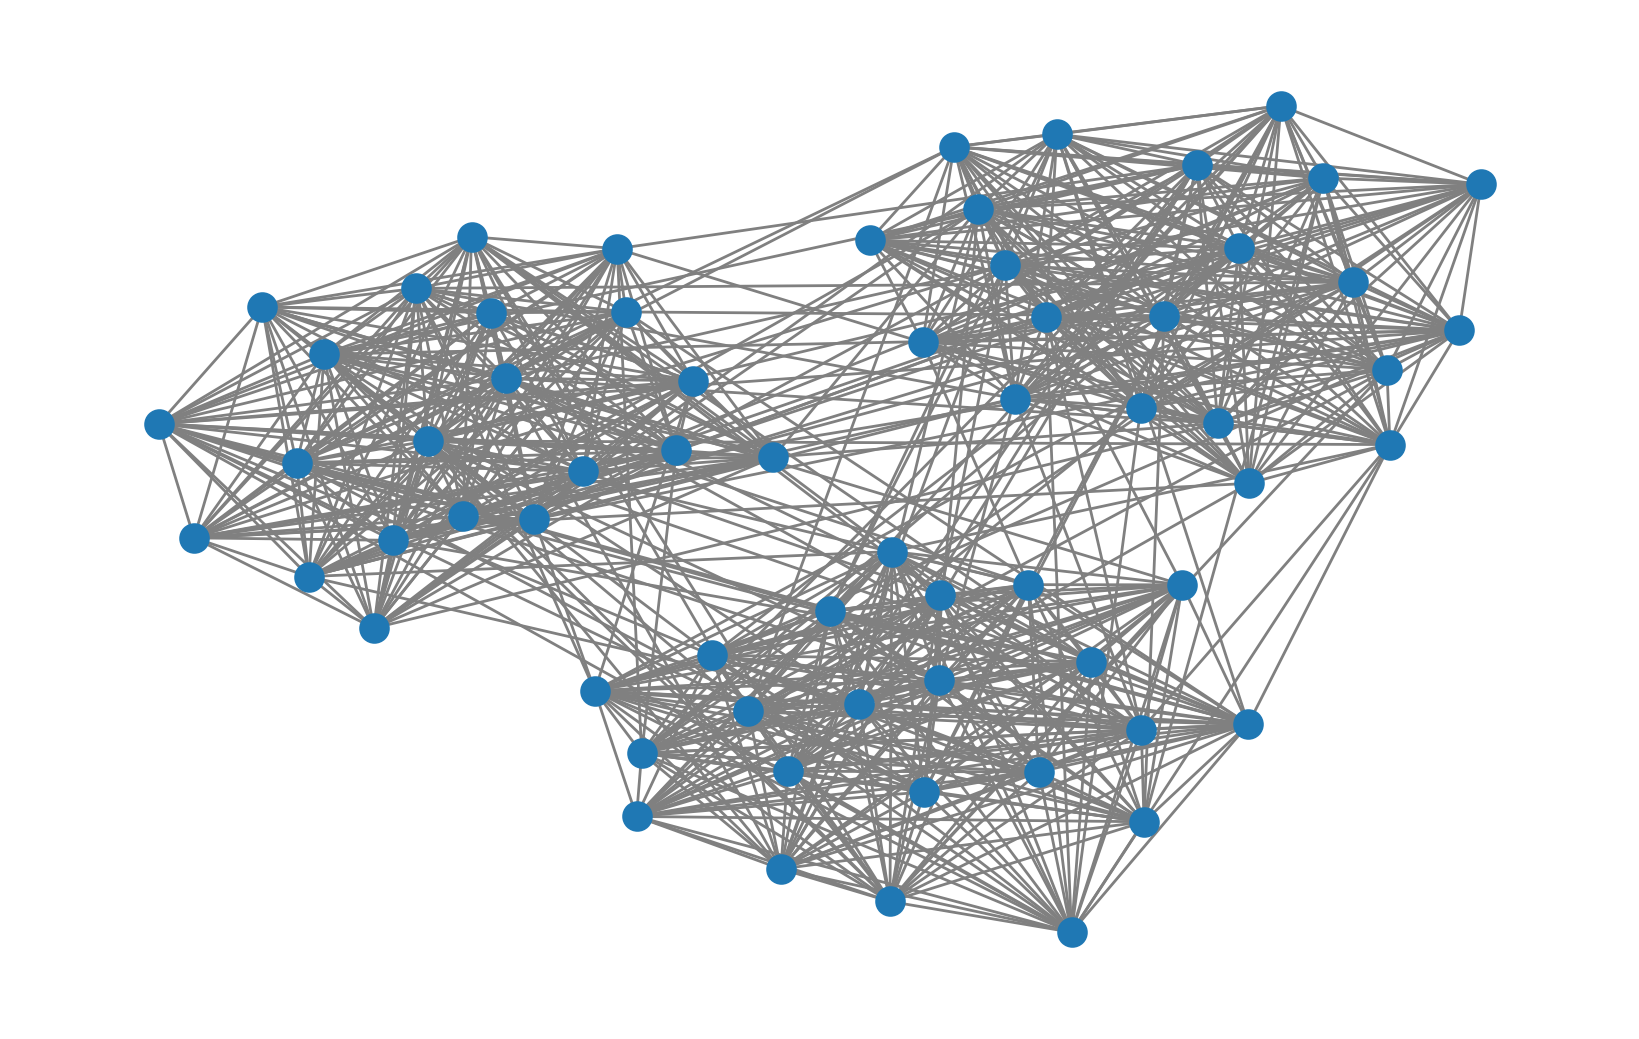

In [21]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

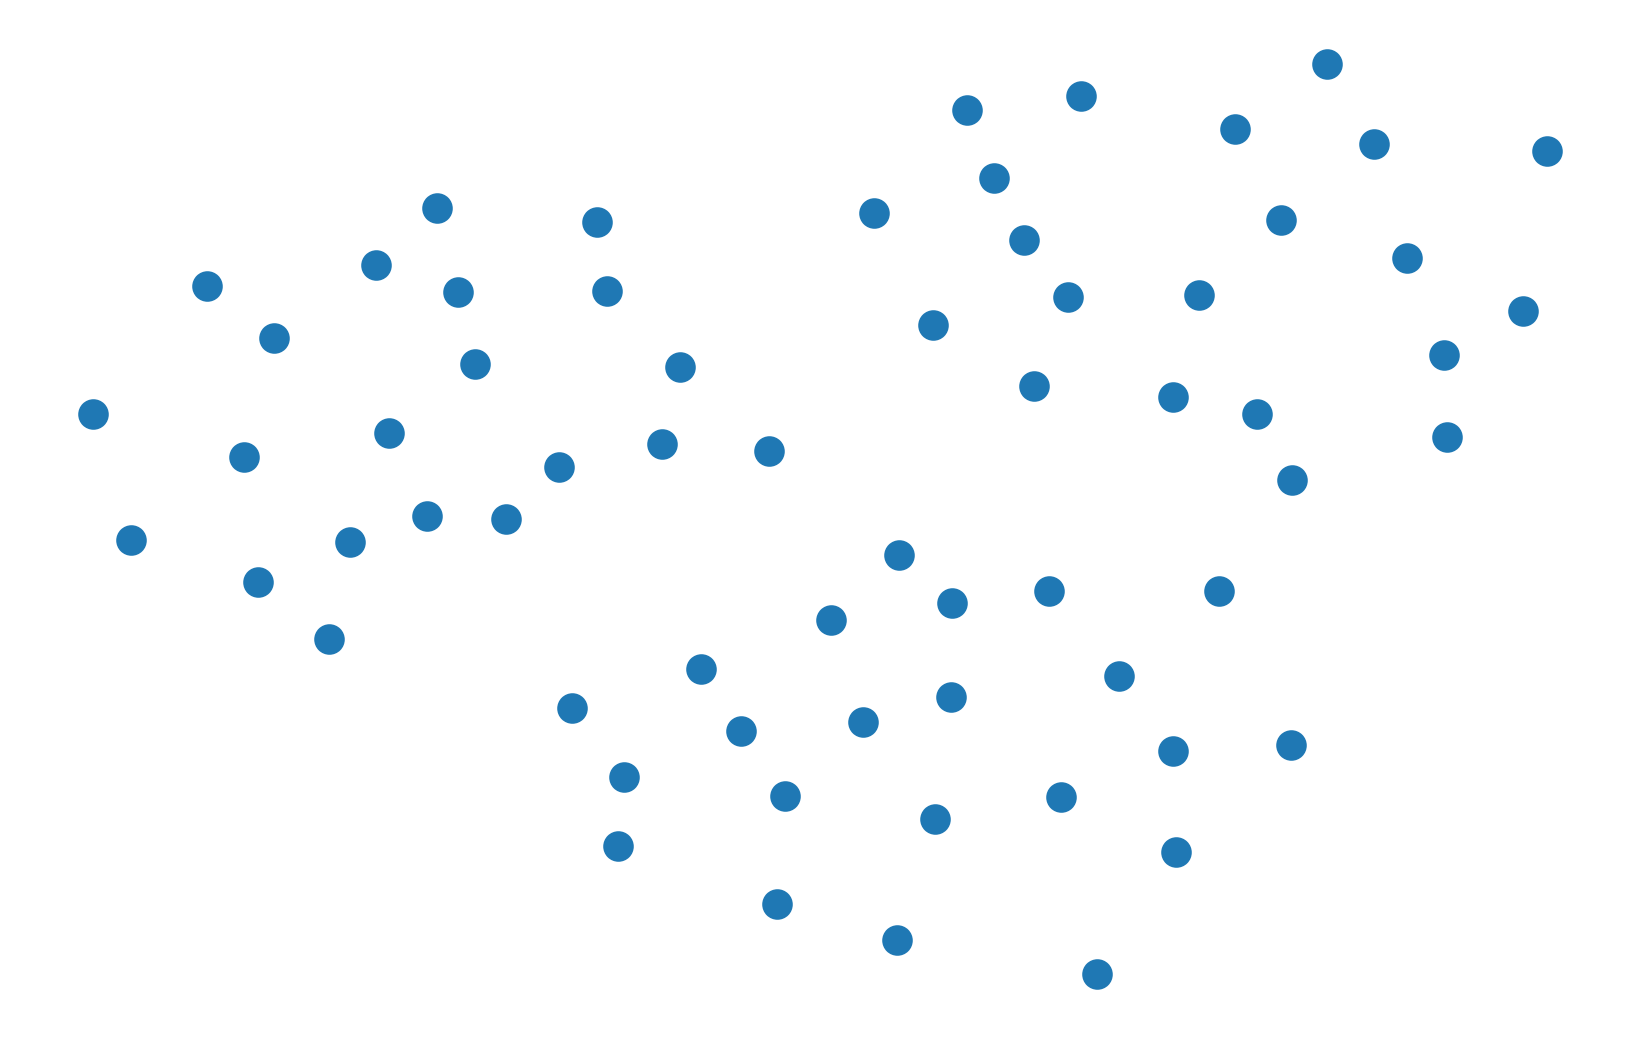

In [23]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

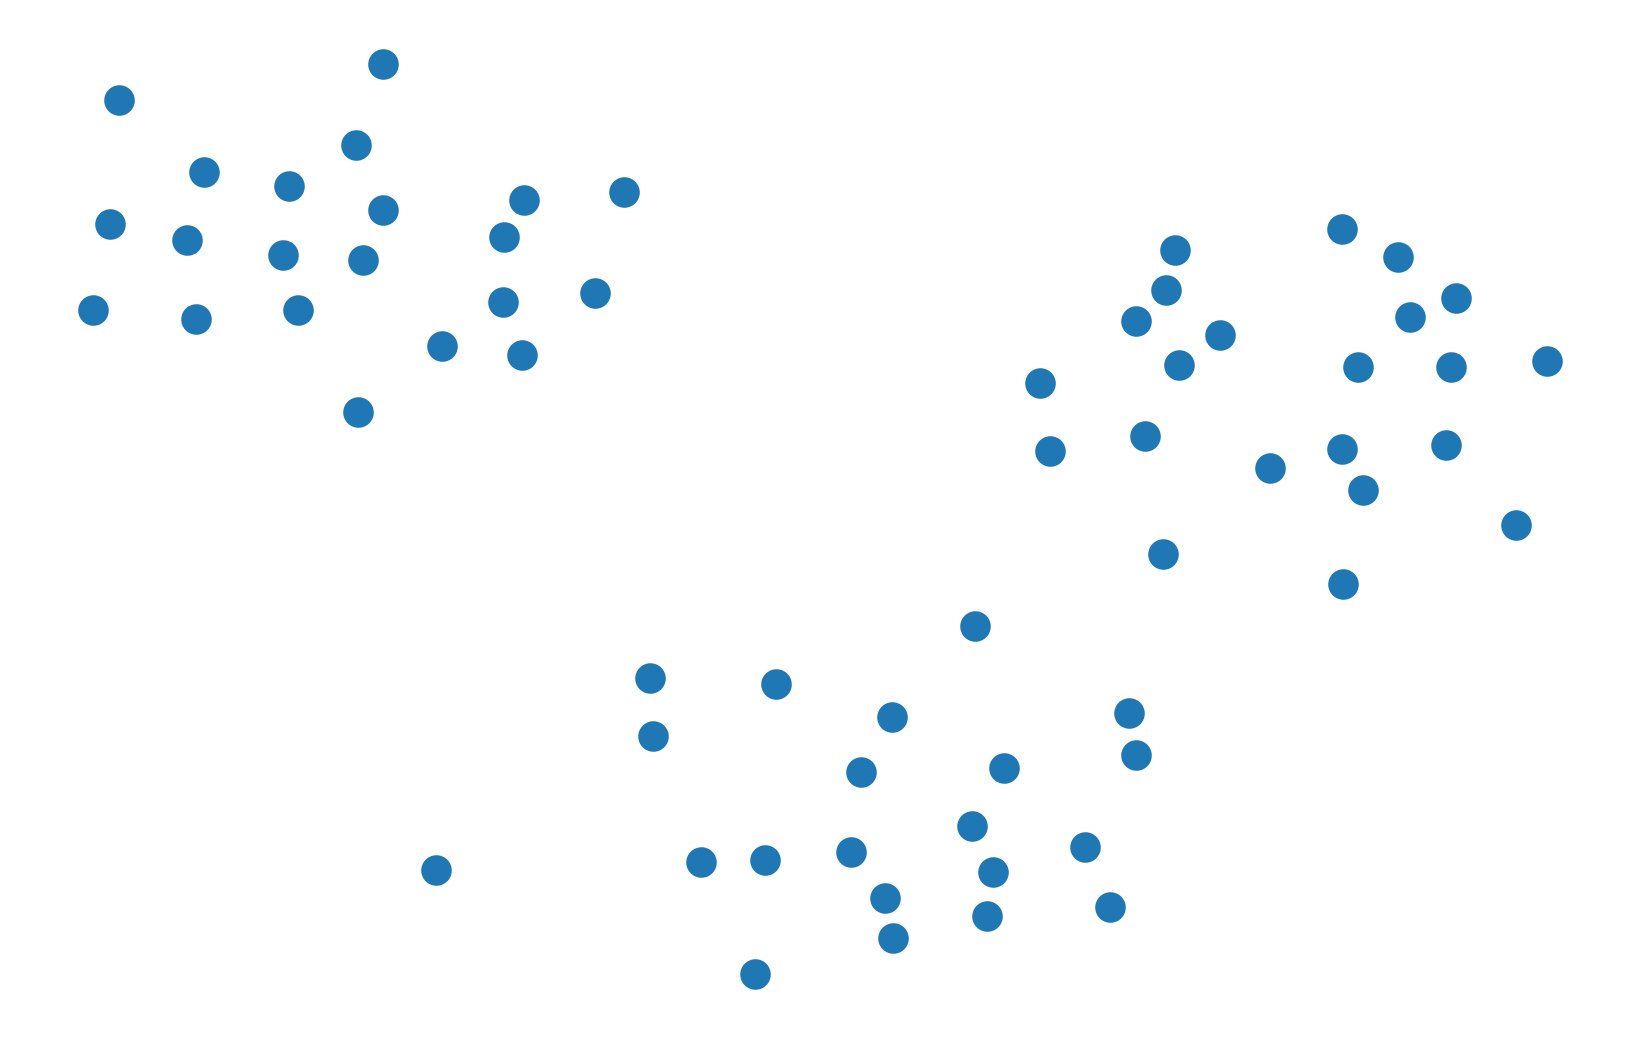

In [27]:
nx.draw(net.g, pos=pos, node_size=100, node_color=node_color, edge_color="gray")

# Verify emprical finding in Sadde's thesis

pin=0.08370535714285715, pout=0.01674107142857143


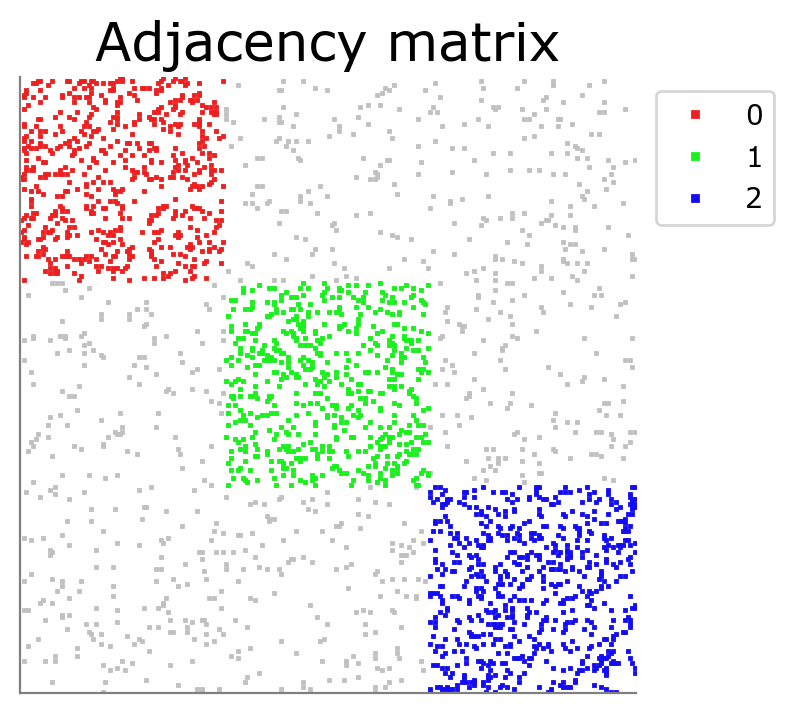

In [10]:
# Symmetric
n = 2**8
k = 3
d = 10
epsilon = 0.2
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

SNR=3.2653061224489797, d=10
(2582, 2582)
[(10.105631315586567+0j), (5.166133152412897+0j), (4.552479652765058+0j)]


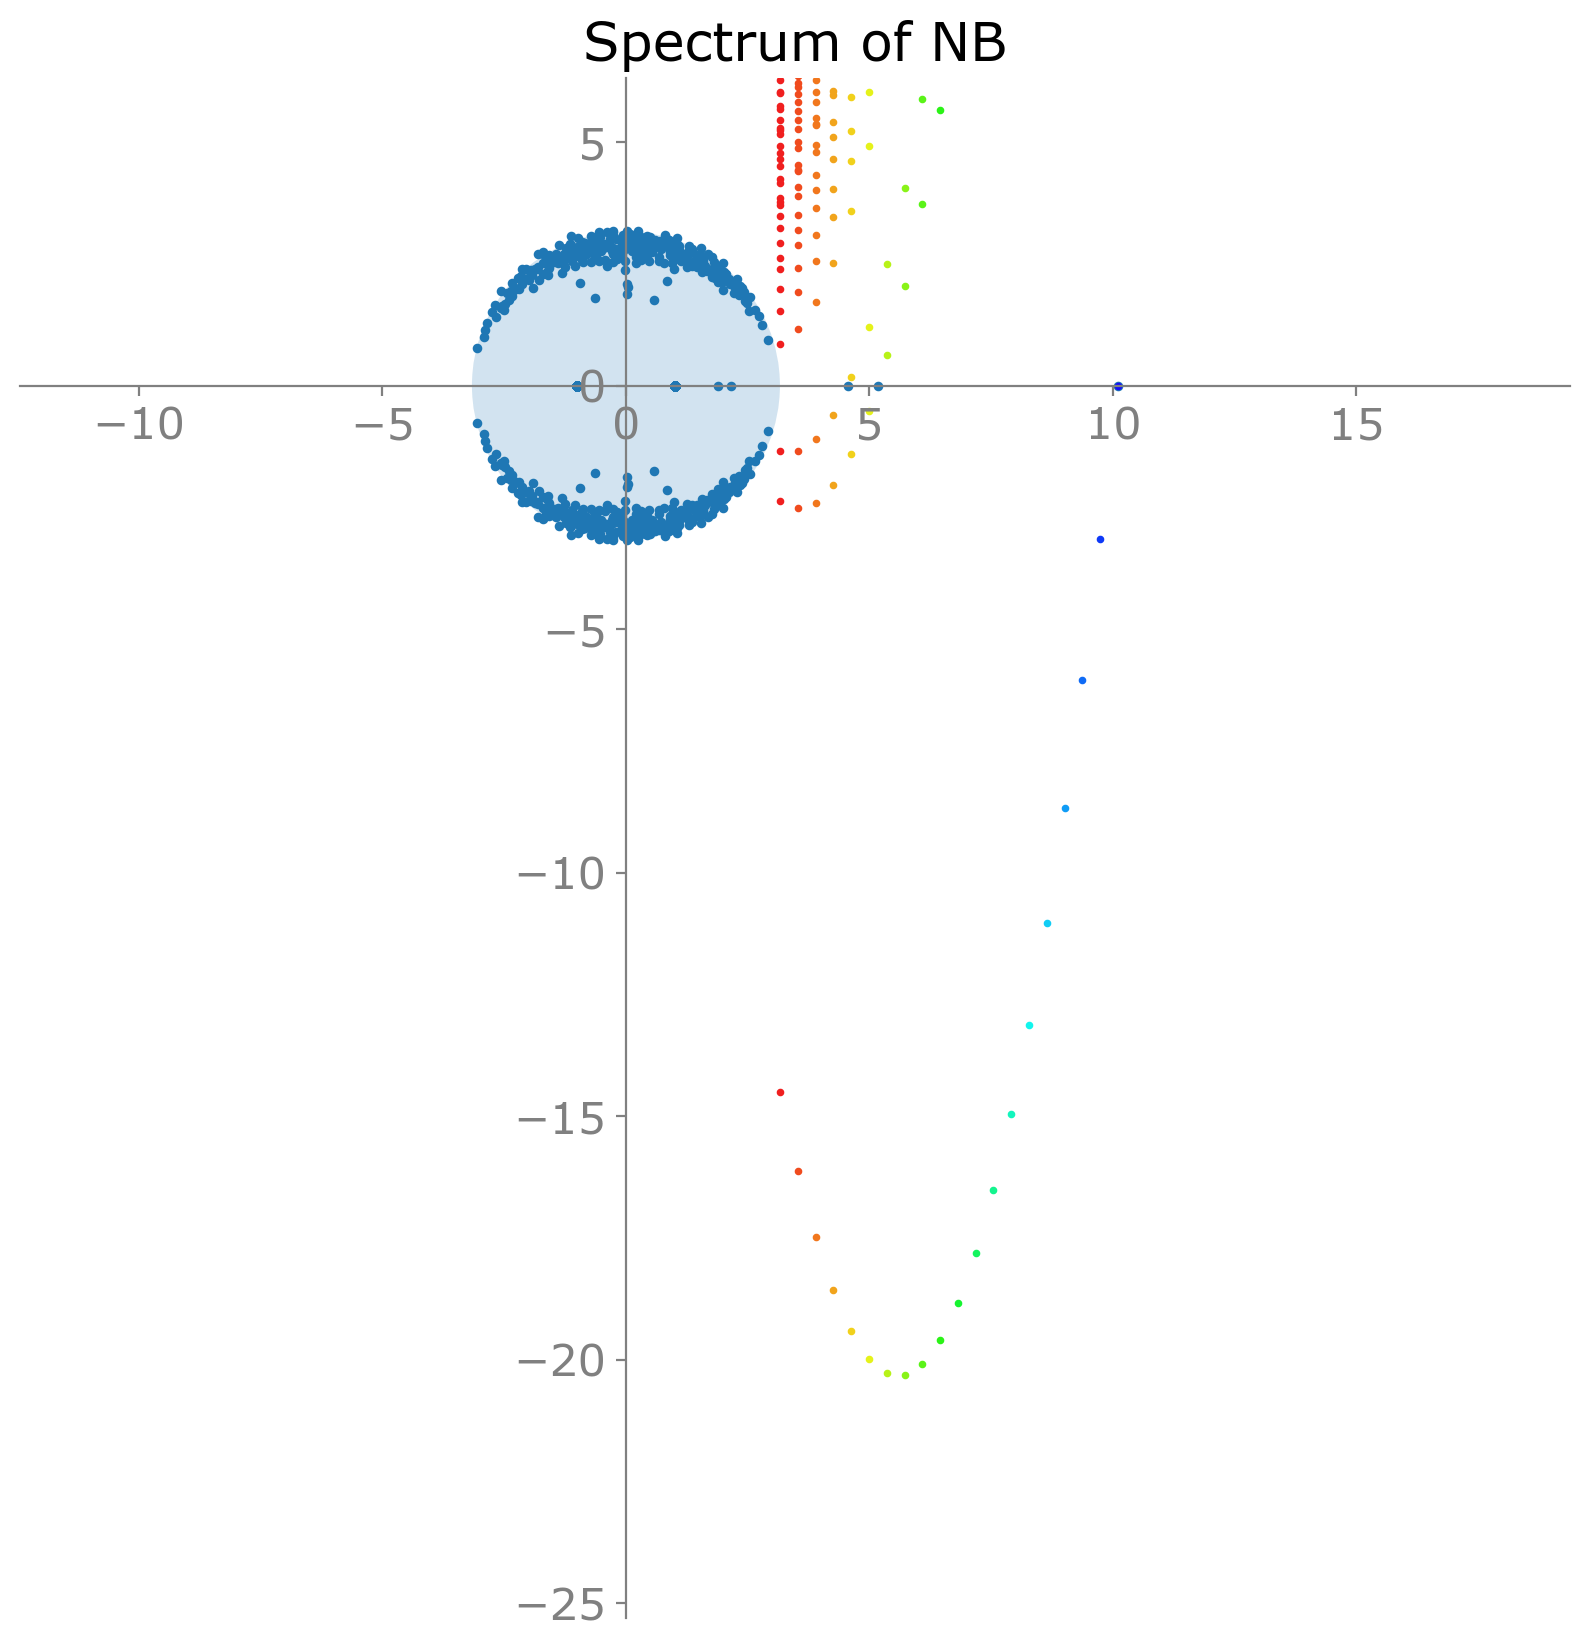

In [31]:
plot_spectral_NBBH(net, d)

pin=0.07142857142857142, pout=0.014285714285714285


D:\BackProgram\Anaconda\envs\network\Lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


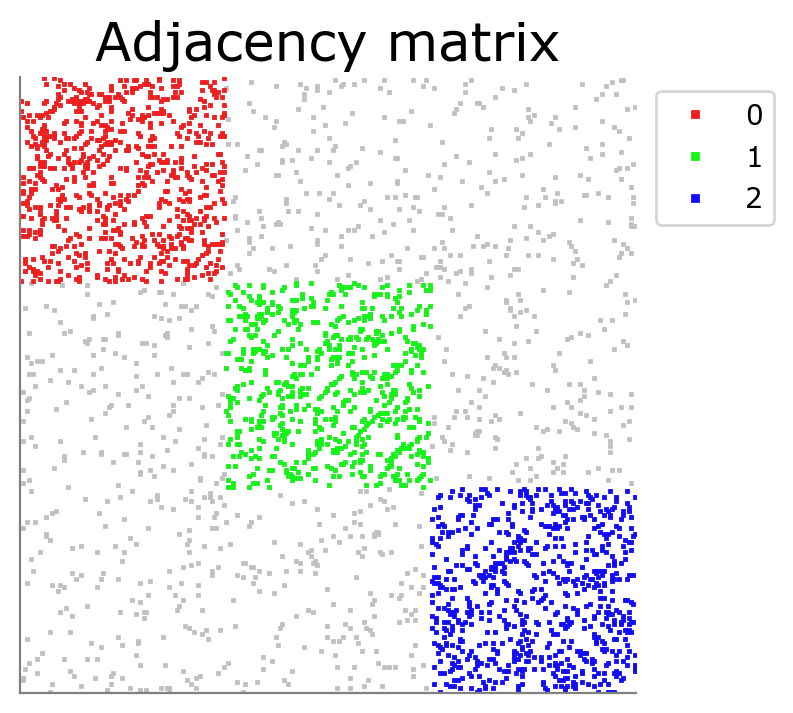

In [6]:
# Symmetric
n = 300
k = 3
d = 10
epsilon = 0.2
net = SymmetricSBM.init_epsc(n, k, d, epsilon)

fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(net.sizes))
plot_block_matrix(net.A.toarray(), partition_names=list(range(len(net.sizes))), partition_counts=net.sizes, colors=c)

SNR=3.2653061224489788, d=10
(3010, 3010)
[(9.996591425278973+0j), (5.517737742605339+0j), (4.515273874148472+0j)]


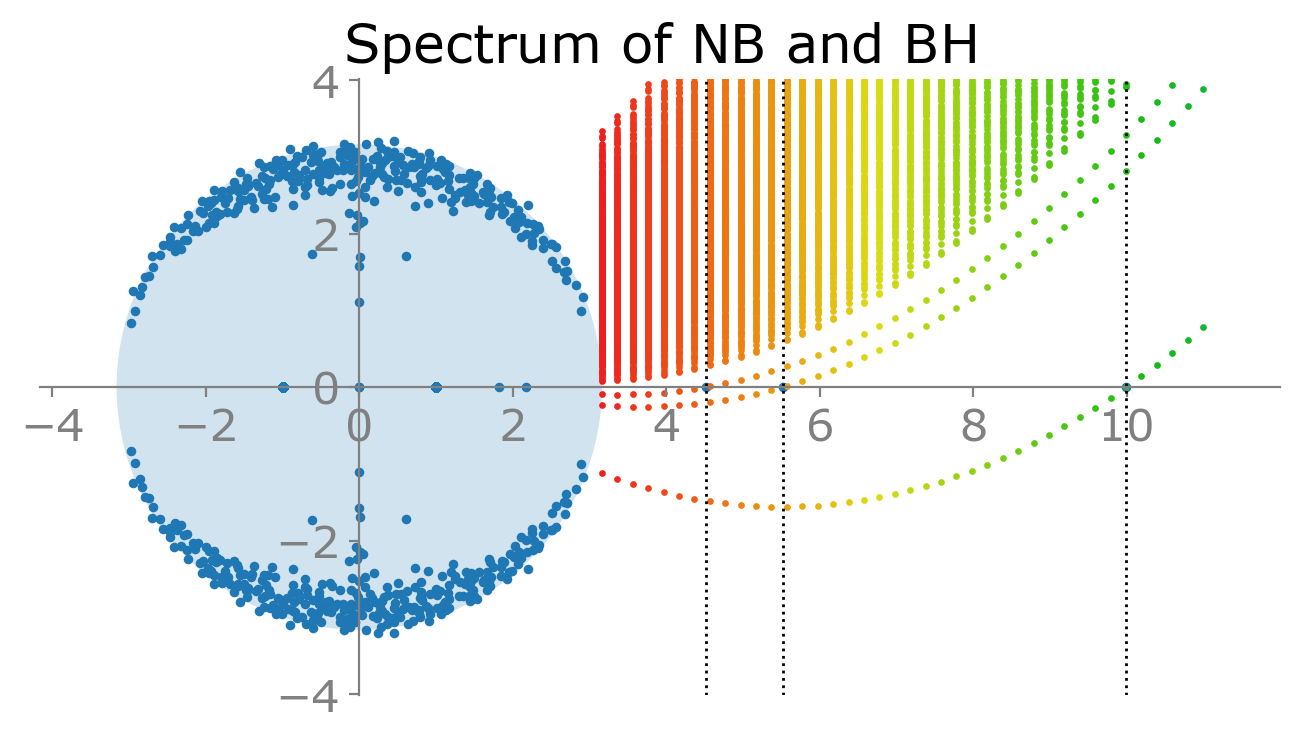

In [35]:
plot_spectral_NBBH(net, d)
save_path = "./_Figure/Bipartite/" + "NBBHspectrum.pdf"
plt.savefig(save_path, dpi=600)

# spectrum of weighted SBM

In [8]:
def scatter_spectral(eigvalue, fig=None, ax=None, title='Spectrum'):
    # Construct scatter coordinate
    x = []
    y = []
    for _w in eigvalue:
        _x = _w.real if isinstance(_w, complex) else _w
        _y = _w.imag if isinstance(_w, complex) else 0
        x.append(_x)
        y.append(_y)
    if fig is None and ax is None:
        fig = plt.figure(figsize=(8, 8))
        widths = [4]
        heights = [4]
        spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
        row = 0
        col = 0
        ax = fig.add_subplot(spec5[row, col])
    plt.axis('equal')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data', 0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.scatter(x, y, s=6)
    ax.set_title(title)

In [29]:
def plot_spectral_NBBH(sbm, d):
    BBT = sbm.A
    R = np.sqrt((BBT**2).sum() / BBT.shape[0])
    NB = sbm.get_operator(operator='WNB')
    print(np.shape(NB), NB.sum())
    eig_B, _ = eig(NB.toarray())
    info_eig = []
    for e in eig_B:
#         print(e, R)
        if abs(e) > R and e.imag == 0:
            info_eig.append(e)
    print(info_eig)
    fig = plt.figure(figsize=(8, 4))
    widths = [5]
    heights = [5]
    spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
    row = 0
    col = 0
    ax = fig.add_subplot(spec5[row, col])
    scatter_spectral(eig_B, fig=fig, ax=ax, title="Spectrum of NB")
    ax.add_patch(Circle(xy = (0.0, 0.0), radius=R, alpha=0.2))
    
    bh_samples = 40
    c = gen_colors(start=colors_red[0], end=colors_green[0], n=bh_samples)
    i = 0
    eig_BHs = dict()
    for r in np.linspace(R, max(info_eig).real+1, bh_samples):
        BH = sbm.get_operator(operator='WBH', r=r)
        eig_BH, _ = eig(BH.toarray())
        eig_BHs[r] = eig_BH
        x = []
        y = []
        for _w in eig_BH:
            _y = _w.real if isinstance(_w, complex) else _w
            x.append(r)
            y.append(_y)
        ax.scatter(x, y, s=1, c=c[i])
        i += 1
    ax.set_ylim(-np.sqrt(d), 2 * np.sqrt(d))
    # subregion zoom
#     x1, x2, y1, y2 = 60, 80, -0.3, 0.05  # subregion of the original image
#     axins = ax.inset_axes(
#         [0.5, 0.6, 0.47, 0.37],
#         xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
#     sub_points_x = []
#     sub_points_y = []
#     sub_points_c = []
#     sub_points_s = []
#     i = 0
#     for r in eig_BHs.keys():
#         if x1 < r < x2:
#             for e in eig_BHs[r]:
#                 if y1 < e < y2:
#                     sub_points_x.append(r)
#                     sub_points_y.append(e)
#                     sub_points_c.append(c[i])
#                     sub_points_s.append(1)
#         i += 1
#     for _w in eig_B:
#         _x = _w.real if isinstance(_w, complex) else _w
#         _y = _w.imag if isinstance(_w, complex) else 0
#         if x1 < _x < x2 and y1 < _y < y2:
#             sub_points_x.append(_x)
#             sub_points_y.append(_y)
#             sub_points_c.append('blue')
#             sub_points_s.append(6)
#     axins.scatter(sub_points_x, sub_points_y, s=sub_points_s, c=sub_points_c)
#     axins.axhline(0, color='grey', lw=1, ls=':')
#     ax.indicate_inset_zoom(axins, edgecolor="black")

In [23]:
sizes = [20, 20, 20]
omegas = np.array([[5, 1, 1], [1, 5, 1], [1, 1, 5]])
sbm = PoissonSBM(sizes, omegas)
d = np.sum(sbm.A) / np.sum(sizes)

1770it [00:00, 30519.20it/s]


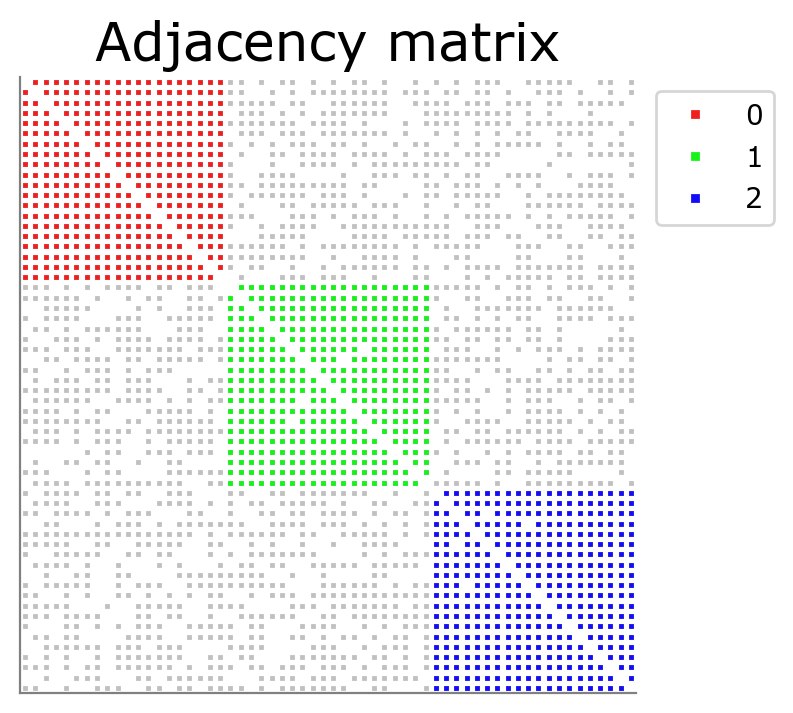

In [24]:
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

(2674, 2674) 354615.0
[(131.40567853088373+0j), (68.18936507533644+0j), (62.23730110610667+0j)]


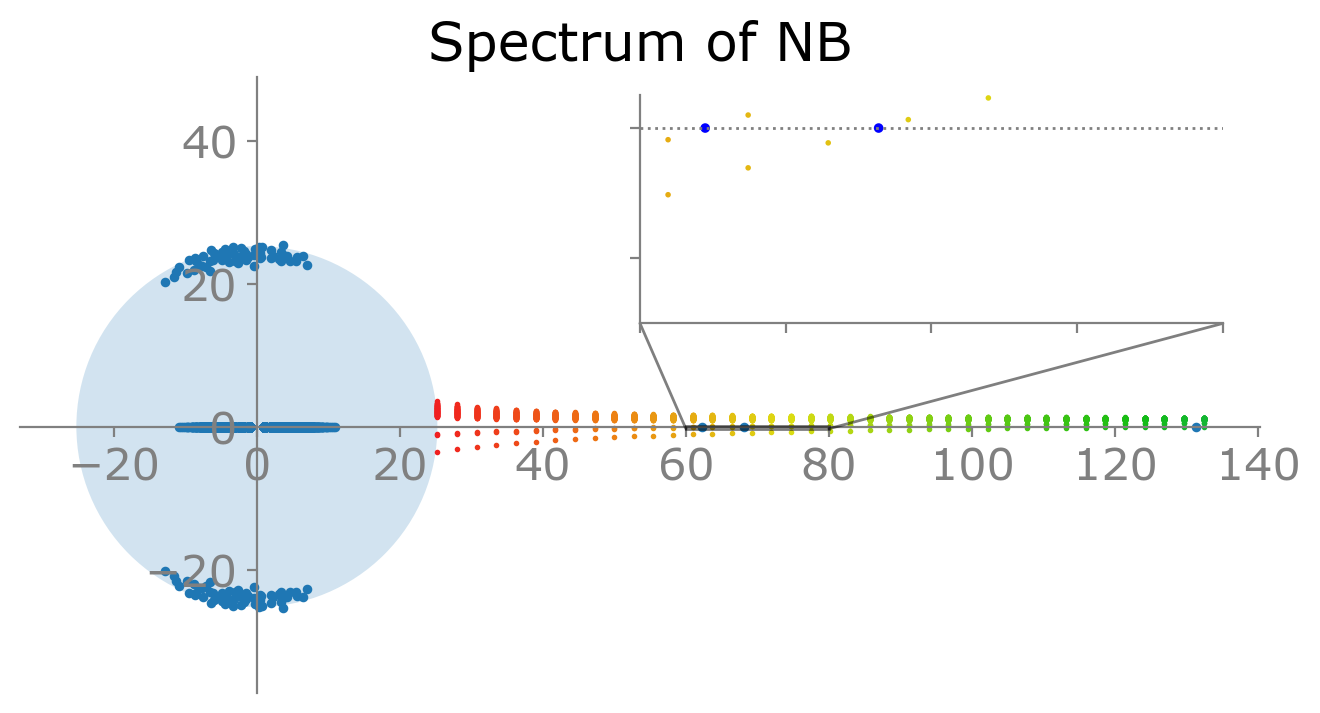

In [25]:
plot_spectral_NBBH(sbm, d)

# fit onemode projection parameter

In [26]:
sizes = [100, 100, 100]
omegas = np.array([[0.187, 0.027, 0.027], [0.027, 0.187, 0.027], [0.027, 0.027, 0.187]])
sbm = PoissonSBM(sizes, omegas)
d = np.sum(sbm.A) / np.sum(sizes)

44850it [00:01, 31787.01it/s]


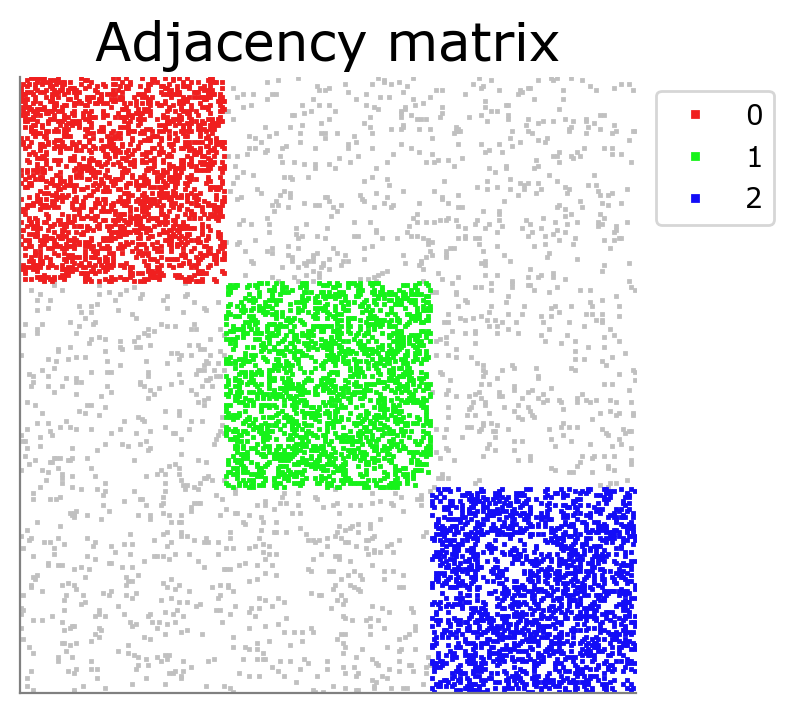

In [27]:
fig = plt.figure(figsize=(4, 4))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(start=colors_red[0], end=colors_blue[0], n=len(sbm.sizes))
plot_block_matrix(sbm.A.toarray(), partition_names=list(range(len(sbm.sizes))), partition_counts=sbm.sizes, colors=c)

(6752, 6752) 161502.0
[(23.930830500875683+0j), (16.271758711498073+0j), (15.79733134442111+0j)]


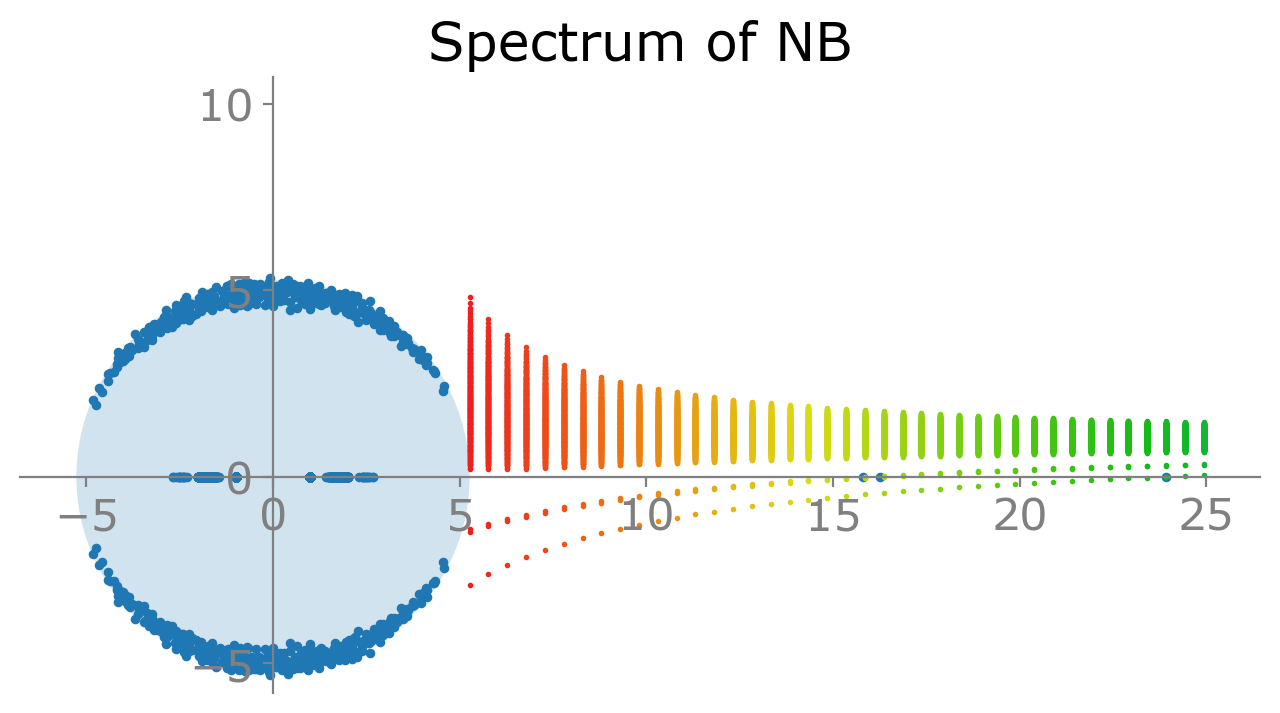

In [30]:
plot_spectral_NBBH(sbm, d)

In [34]:
np.unique(sbm.A.toarray(), return_counts=True)

(array([0., 1., 2., 3.]), array([83248,  6278,   444,    30], dtype=int64))